In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.xception import preprocess_input  # Adjusted import for Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

In [ ]:
# Check available GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Print information about each GPU
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Type:", gpu.device_type)
else:
    print("No GPU available, using CPU instead")


In [2]:
train_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/test/test'
img_size = (299, 299) 
batch_size = 16
epochs = 10
patience = 5


In [3]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=60,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 468 images belonging to 17 classes.


In [4]:
# Build the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) 

In [5]:
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu',kernel_regularizer=l2(0.001)),
    Dropout(0.7),
    Dense(train_generator.num_classes, activation='softmax')
])


In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Define callbacks
checkpoint = ModelCheckpoint('models/reduced_xception_plant_disease_detection.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)


In [8]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping] 
)

Epoch 1/10
796/796 [==============================] - ETA: 0s - loss: 2.4279 - accuracy: 0.3132
Epoch 1: val_accuracy improved from -inf to 0.71888, saving model to models\reduced_xception_plant_disease_detection.h5
796/796 [==============================] - 389s 474ms/step - loss: 2.4279 - accuracy: 0.3132 - val_loss: 1.2236 - val_accuracy: 0.7189
Epoch 2/10
796/796 [==============================] - ETA: 0s - loss: 1.9017 - accuracy: 0.4482
Epoch 2: val_accuracy improved from 0.71888 to 0.79662, saving model to models\reduced_xception_plant_disease_detection.h5
796/796 [==============================] - 316s 397ms/step - loss: 1.9017 - accuracy: 0.4482 - val_loss: 0.9047 - val_accuracy: 0.7966
Epoch 3/10
796/796 [==============================] - ETA: 0s - loss: 1.6984 - accuracy: 0.4995
Epoch 3: val_accuracy improved from 0.79662 to 0.80904, saving model to models\reduced_xception_plant_disease_detection.h5
796/796 [==============================] - 348s 437ms/step - loss: 1.6984 - 

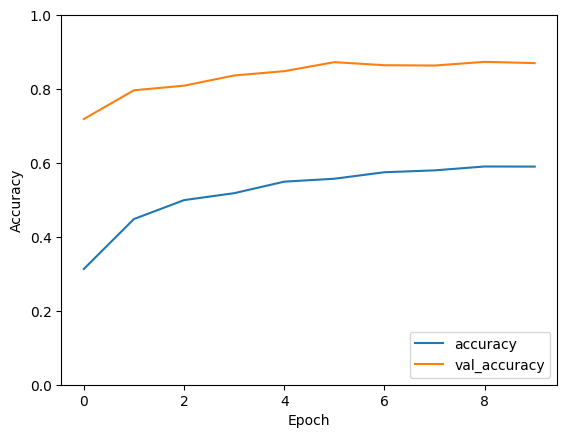

In [9]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [6]:
# Load model
model = load_model('models/xception_plant_disease_detection.h5')

In [10]:
# Evaluate the model on test generator
test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)


C:\Users\Nabu\AppData\Local\Temp\ipykernel_21528\2128755816.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, verbose=1)


30/30 [==============================] - 8s 254ms/step - loss: 0.5788 - accuracy: 0.8782
Test Accuracy: 0.8782051205635071
Test Loss: 0.5787956118583679


In [11]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}


In [12]:
# Save class indices to a JSON file
with open('class_indices_xception.json', 'w') as f:
    json.dump(class_indices, f)

In [13]:
# Load class indices
with open('class_indices_xception.json', 'r') as f:
    class_indices = json.load(f)

# Load remedies
with open('remedies.json', 'r') as f:
    remedies= json.load(f)

In [14]:
# Function to predict disease from an image
def predict_disease(image_path):

    img = load_img(image_path, target_size=(img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)[0]
    predicted_class_index = np.argmax(prediction)
    disease = class_indices[str(predicted_class_index)]
    confidence = prediction[predicted_class_index]

    return disease, confidence 

In [16]:
image_path = 'D:/testproject/dataset/PlantDiseasesDataset/Apple/train/Apple Healthy/AppleHealthy(4).JPG' 

disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')

if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')

1/1 [==============================] - 0s 53ms/step
Predicted Disease: Potato___healthy, Confidence: 0.9575740098953247
Remedies: Remedies for Healthy Potato
